In [1]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        # y = np.log1p(y)
        y = np.log1p(y - np.min(y) + 1)


    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test.flatten()

    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 PyTorch FNN Performance (All Cells):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Save model if required
    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    # Visualization (same as before - omitted here for brevity)
    # You can copy/paste from your original script if needed.


    # return model, mse, r2
    return model, mse, r2, train_losses



def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        # 1. Training Loss Curve
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 2. Residuals vs Predicted
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # 3. Predicted vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    # 4. Residual Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # 5. Cumulative Distribution of Absolute Errors
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6. Q-Q Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    # 7. Absolute Error vs Actual
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model_name = f"fnn_lr{lr}_bs{batch_size}_ep{epochs}_hl{'x'.join(map(str, hidden_sizes))}.pt"

        model, mse, r2, train_losses = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False  # Save only best model later
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs,
                "model_name": model_name
            }
            best_model = model
            if save_best_model:
                torch.save(model.state_dict(), model_name)
                print(f"💾 New best model saved as: {model_name}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    if best_model and save_best_model:
        df = pd.read_csv(csv_path)
        df = df.dropna(subset=features + ["X_Centroid_Velocity_MA"])

        X = df[features].values.astype(np.float32)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        y = df["X_Centroid_Velocity_MA"].values.astype(np.float32).reshape(-1, 1)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            y_pred_tensor = best_model(X_tensor)
        y_pred = y_pred_tensor.numpy().flatten()
        y_true = y.flatten()

        plot_results(y_true, y_pred,train_losses=train_losses)

    return best_model, best_config, results_df



# Define the hyperparameter search space
param_grid = {
    "lr": [0.001,0.0001, 0.0005],
    "batch_size": [8,16, 32],
    "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200,300,400,500]
}


best_model, best_config, results_df = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)

# Print best model details
print("\n🏆 Best Model Details:")
print(best_config)

# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")
else:
    print("❌ No best model was found.")



# window_size = 5
# frame_num = 30
# output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
# csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")


window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")



🔍 [1/315] Testing config: lr=0.001, batch_size=8, hidden_sizes=(256, 128, 64), epochs=100

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 0.8011
Epoch 10/100 - Loss: 0.1029
Epoch 20/100 - Loss: 0.0931
Epoch 30/100 - Loss: 0.0819
Epoch 40/100 - Loss: 0.0778
Epoch 50/100 - Loss: 0.0865
Epoch 60/100 - Loss: 0.0740
Epoch 70/100 - Loss: 0.0646
Epoch 80/100 - Loss: 0.0646
Epoch 90/100 - Loss: 0.0612
Epoch 100/100 - Loss: 0.0625

📊 PyTorch FNN Performance (All Cells):
Mean Squared Error (MSE): 7.3660
R-squared: 0.1238
💾 New best model saved as: fnn_lr0.001_bs8_ep100_hl256x128x64.pt

🔍 [2/315] Testing config: lr=0.001, batch_size=8, hidden_sizes=(256, 128, 64), epochs=200

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/200 - Loss: 0.7742
Epoch 10/200 - Loss: 0.1089
Epoch 20/200 - Loss: 0.1037
Epoch 30/200 - Loss: 0.0931
Epoch 40/200 - Loss: 0.0903
Epoch 50/200 - Loss: 0.0769
Epoch 60/200 - Loss: 0.0754
Epoch 70/200 - Loss: 0.0665
Epoch 8

KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform=True):
    """
    Evaluate the trained model on test data and compute MSE, R².
    """
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()
    
    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("\n📊 **Model Evaluation on Test Data:**")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")
    
    return mse, r2


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor, apply_log_transform)

    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    return model, mse, r2, train_losses, X_test_tensor, y_test_tensor


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs
            }
            best_model = model

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    return best_model, best_config, results_df




param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

best_model, best_config, results_df = grid_search_fnn(
    csv_path="your_data.csv",
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)


📂 CSV file found! Running FNN...

🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)
Epoch 1/100 - Loss: 4.6502
Epoch 10/100 - Loss: 3.5322
Epoch 20/100 - Loss: 2.6011
Epoch 30/100 - Loss: 1.8770
Epoch 40/100 - Loss: 1.3210
Epoch 50/100 - Loss: 0.9087
Epoch 60/100 - Loss: 0.6129
Epoch 70/100 - Loss: 0.4087
Epoch 80/100 - Loss: 0.2783
Epoch 90/100 - Loss: 0.1979
Epoch 100/100 - Loss: 0.1560

📊 **Model Evaluation on Test Data:**
✅ Test Mean Squared Error (MSE): 13.0118
✅ Test R-squared (R²): -0.5478


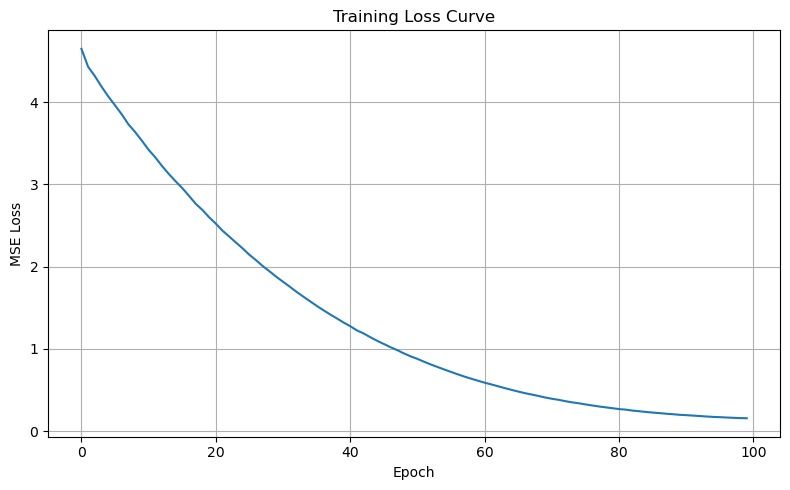

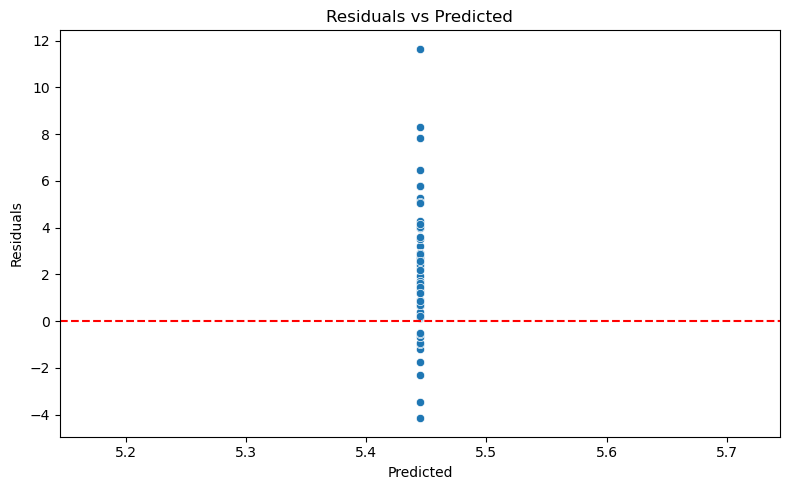

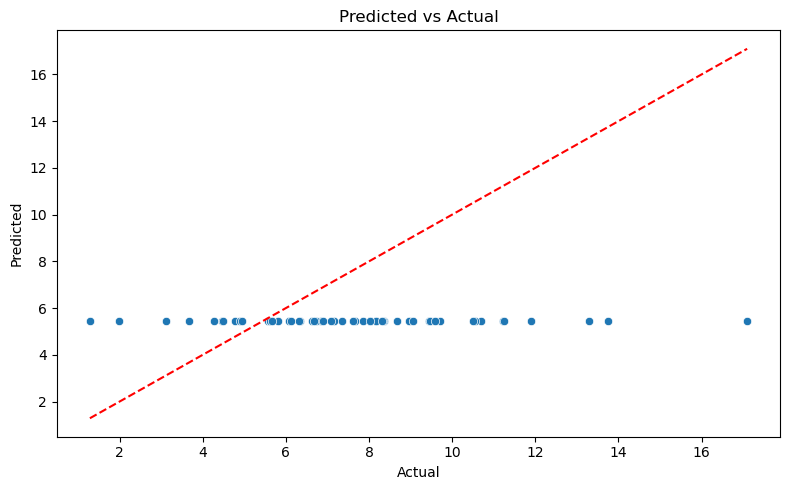

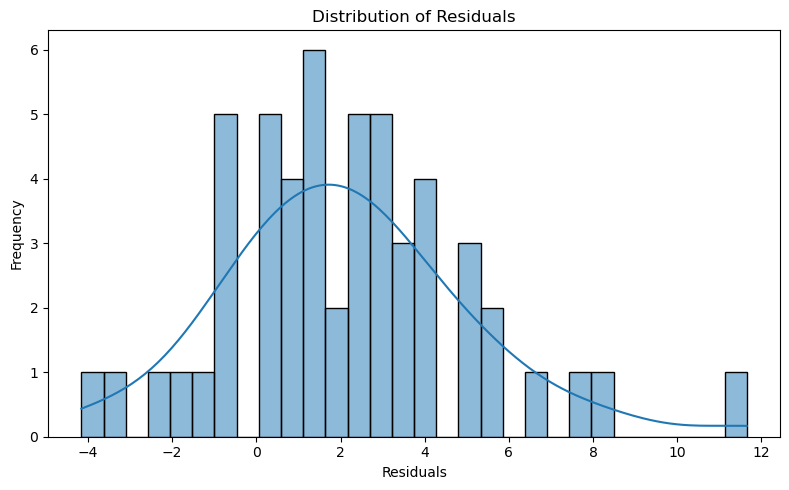

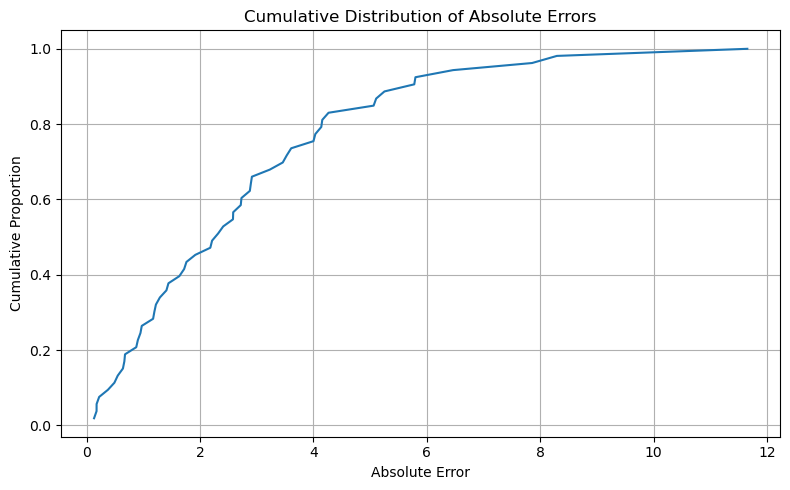

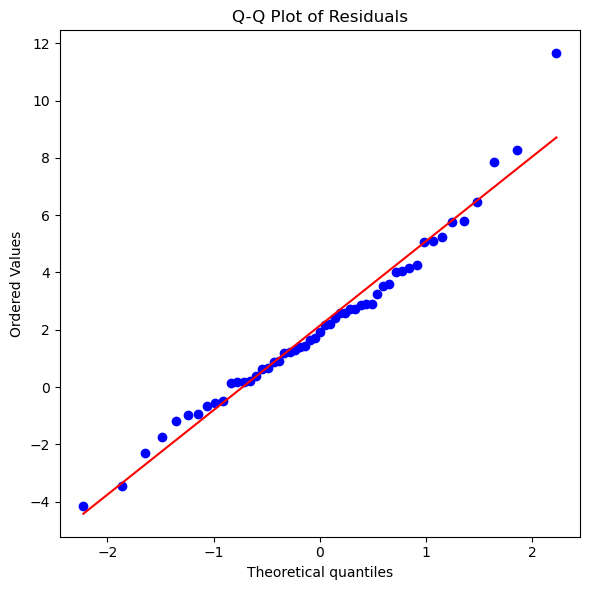

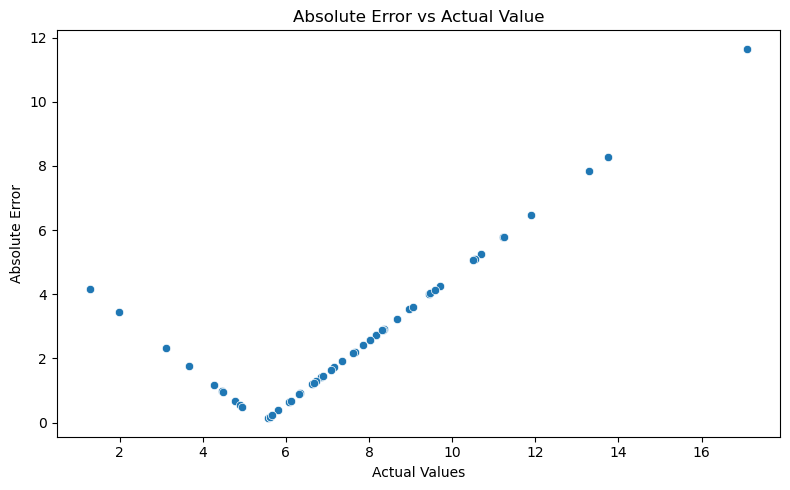

ValueError: too many values to unpack (expected 4)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import product


class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(FNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, X_test_tensor, y_test_tensor, train_losses=None, apply_log_transform=True):
    """
    Evaluate the trained model on test data and compute MSE, R².
    Also applies the plot_results function to visualize model performance.
    """
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    
    y_pred = y_pred_tensor.numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()
    
    if apply_log_transform:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("\n📊 **Model Evaluation on Test Data:**")
    print(f"✅ Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Test R-squared (R²): {r2:.4f}")
    
    # Plot the results for the test set
    plot_results(y_true, y_pred, train_losses)
    
    return mse, r2, y_true, y_pred


def run_fnn_pytorch(csv_path, epochs=100, batch_size=16, lr=0.001,
                    hidden_sizes=(128, 128, 64, 64, 32, 32, 16, 8),
                    apply_log_transform=True, save_model=False, model_save_path="fnn_model.pth"):
    df = pd.read_csv(csv_path)
    print(f"\n🔍 Running PyTorch FNN Regression on FULL dataset (All Cells)")

    features = ["Area_MA", "Perimeter_MA", "Extent_MA", "Solidity_MA",
                "Compactness_MA", "Elongation_MA", "Circularity_MA", "Convexity_MA"]
    target = "X_Centroid_Velocity_MA"

    missing_cols = [col for col in features + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    df = df.dropna(subset=features + [target])

    X = df[features].values.astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df[target].values.astype(np.float32).reshape(-1, 1)
    if apply_log_transform:
        y = np.log1p(y - np.min(y) + 1)

    mask = ~np.isnan(y.flatten())
    X = X[mask]
    y = y[mask]

    if len(X) < 10:
        print("⚠ Small dataset, using full data for both training and testing.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FNN(input_size=X.shape[1], hidden_sizes=hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    model.eval()
    mse, r2, y_true, y_pred = evaluate_model(model, X_test_tensor, y_test_tensor, train_losses, apply_log_transform)

    if save_model:
        torch.save(model.state_dict(), model_save_path)
        print(f"💾 Model saved to {model_save_path}")

    return model, mse, r2, train_losses, X_test_tensor, y_test_tensor



def plot_results(y_true, y_pred, train_losses=None):
    residuals = y_true - y_pred

    if train_losses is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title("Residuals vs Predicted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='red')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    absolute_errors = np.abs(residuals)
    sorted_errors = np.sort(absolute_errors)
    cum_dist = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    plt.plot(sorted_errors, cum_dist)
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Proportion")
    plt.title("Cumulative Distribution of Absolute Errors")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=absolute_errors)
    plt.title("Absolute Error vs Actual Value")
    plt.xlabel("Actual Values")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.show()


def grid_search_fnn(csv_path, param_grid, save_best_model=True, output_results_csv="fnn_gridsearch_results.csv"):
    results = []
    best_r2 = -float("inf")
    best_config = None
    best_model = None

    all_combinations = list(product(
        param_grid["lr"],
        param_grid["batch_size"],
        param_grid["hidden_sizes"],
        param_grid["epochs"]
    ))

    for i, (lr, batch_size, hidden_sizes, epochs) in enumerate(all_combinations, 1):
        print(f"\n🔍 [{i}/{len(all_combinations)}] Testing config: lr={lr}, batch_size={batch_size}, hidden_sizes={hidden_sizes}, epochs={epochs}")

        model, mse, r2, train_losses, X_test_tensor, y_test_tensor = run_fnn_pytorch(
            csv_path=csv_path,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            hidden_sizes=hidden_sizes,
            apply_log_transform=True,
            save_model=False
        )

        results.append({
            "lr": lr,
            "batch_size": batch_size,
            "hidden_sizes": str(hidden_sizes),
            "epochs": epochs,
            "mse": round(mse, 4),
            "r2": round(r2, 2)
        })

        if r2 > best_r2:
            best_r2 = r2
            best_config = {
                "lr": lr,
                "batch_size": batch_size,
                "hidden_sizes": hidden_sizes,
                "epochs": epochs
            }
            best_model = model

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_results_csv, index=False)
    print(f"\n✅ Grid Search Summary saved to: {output_results_csv}")
    print(f"🏆 Best R² = {best_r2:.4f} | Best Config = {best_config}")

    if best_model:
        mse, r2, y_true, y_pred = evaluate_model(best_model, X_test_tensor, y_test_tensor)
        plot_results(y_true, y_pred, train_losses)

    return best_model, best_config, results_df




window_size = 5
frame_num = 30
output_directory = "/home/MinaHossain/EmbedTrack/PCA_t-SNE_PHATE/"
csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{frame_num}.csv")

if os.path.exists(csv_path):
    print("📂 CSV file found! Running FNN...")
    model, mse, r2, train_losses = run_fnn_pytorch(csv_path=csv_path, epochs=100, batch_size=16, lr=0.001)
    print(f"✅ Done. MSE: {mse:.4f} | R²: {r2:.4f}")
else:
    print("❌ CSV file not found. Check the path and try again.")



# Define the hyperparameter search space
# param_grid = {
#     "lr": [0.001,0.0001, 0.0005],
#     "batch_size": [8,16, 32],
#     "hidden_sizes": [(256, 128, 64),(128, 64, 32),(256, 128, 64, 64, 32, 32, 16, 8) ,(64, 32, 16, 8),(256, 128, 64, 32, 16, 8),(512, 256, 128, 64, 32, 32, 16, 8),(128, 128, 64, 64, 32, 32, 16, 8)],
#     "epochs": [100, 200,300,400,500]
# }

param_grid = {
    "lr": [0.001, 0.0005],
    "batch_size": [16, 32],
    "hidden_sizes": [(128, 64, 32), (128, 128, 64, 64, 32, 32, 16, 8)],
    "epochs": [100, 200]
}

best_model, best_config, results_df = grid_search_fnn(
    csv_path=csv_path,
    param_grid=param_grid,
    save_best_model=True,
    output_results_csv="grid_search_results.csv"
)

# Print best model details
print("\n🏆 Best Model Details:")
print(best_config)

# Print model layer details
if best_model:
    print("\n🧠 Model Architecture:")
    print(best_model)
    print(f"\n💾 Best model is saved as: {best_config['model_name']}")
else:
    print("❌ No best model was found.")

